<a href="https://colab.research.google.com/github/Boyinglby/ADL_lab/blob/main/DL_lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from matplotlib import pyplot
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk import word_tokenize
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report

# Task 1.1 Simple chatbot

# Load and preprocess data

In [ ]:
def preprocess_pandas(data, columns):
    df_ = pd.DataFrame(columns=columns)
    data['Sentence'] = data['Sentence'].str.lower()
    data['Sentence'] = data['Sentence'].replace('[a-zA-Z0-9-_.]+@[a-zA-Z0-9-_.]+', '', regex=True)                      # remove emails
    data['Sentence'] = data['Sentence'].replace('((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.|$)){4}', '', regex=True)    # remove IP address
    data['Sentence'] = data['Sentence'].str.replace('[^\w\s]','')                                                       # remove special characters
    data['Sentence'] = data['Sentence'].replace('\d', '', regex=True)                                                   # remove numbers
    for index, row in data.iterrows():
        word_tokens = word_tokenize(row['Sentence'])
        filtered_sent = [w for w in word_tokens if not w in stopwords.words('english')]
        df_ = pd.concat([df_, pd.DataFrame({
            "index": row['index'],
            "Class": row['Class'],
            "Sentence": " ".join(filtered_sent[0:])
        }, index = [row['index']])],ignore_index=True)
    return df_

In [ ]:
# get data, pre-process and split
data = pd.read_csv("amazon_cells_labelled.txt", delimiter='\t', header=None)
data.columns = ['Sentence', 'Class']
data['index'] = data.index                                          # add new column index
columns = ['index', 'Class', 'Sentence']

In [ ]:
# Import the NLTK library
import nltk
nltk.download('punkt')
nltk.download('stopwords')
data = preprocess_pandas(data, columns)                             # pre-process


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
training_data_r, validation_data_r, training_labels, validation_labels = train_test_split( # split the data into training, validation, and test splits
        data['Sentence'].values.astype('U'),
        data['Class'].values.astype('int32'),
        test_size=0.10,
        random_state=0,
        shuffle=True
    )

In [ ]:
# vectorize data using TFIDF and transform for PyTorch for scalability
word_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,2), max_features=50000, max_df=0.5, use_idf=True, norm='l2')
training_data = word_vectorizer.fit_transform(training_data_r)        # transform texts to sparse matrix
training_data = training_data.todense()                             # convert to dense matrix for Pytorch

vocab_size = len(word_vectorizer.vocabulary_)

validation_data = word_vectorizer.transform(validation_data_r)
validation_data = validation_data.todense()

train_x_tensor = torch.from_numpy(np.array(training_data)).type(torch.FloatTensor)
train_y_tensor = torch.from_numpy(np.array(training_labels)).long()

validation_x_tensor = torch.from_numpy(np.array(validation_data)).type(torch.FloatTensor)
validation_y_tensor = torch.from_numpy(np.array(validation_labels)).long()

# LSTM model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random

out_nr = 2

class LSTM(nn.Module):
    def __init__(self, hidden_size = 25):
        super(LSTM, self).__init__()
        num_layers = 1
        # Recurrent layer
        self.lstm = nn.LSTM(input_size=vocab_size,
                         hidden_size=hidden_size,
                         num_layers=num_layers,
                         bidirectional=False)

        # Output layer
        self.l_out = nn.Linear(in_features=hidden_size,
                            out_features=out_nr,
                            bias=False)

    def forward(self, x):
        # RNN returns output and last hidden state
        x, (h, c) = self.lstm(x)

        # Flatten output for feed-forward layer
        x = x.view(-1, self.lstm.hidden_size)

        # Output layer
        x = self.l_out(x)

        return x

    def generate_resp(self,x):
      response = {0:["sorry for the bad experience", "please contact the service for help", "We are improving"],
                  1:["Thank you for the feedback", "we are glad you like it"]}
      output = self.forward(x)
      analysis = np.argmax(output[0].detach().numpy())
      print(random.choice(response[analysis]))



In [ ]:
# Initialise our network
model = LSTM()
print(model)
min_LSTM_loss = 10000

# Define a loss function and optimizer for this problem
criterion = nn.CrossEntropyLoss()
# criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-3)
# A way to get learning rate decay
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.9)

LSTM(
  (lstm): LSTM(5145, 25)
  (l_out): Linear(in_features=25, out_features=2, bias=False)
)


In [ ]:
# one hot encode label
to_onehot = nn.Embedding(1, 2)
to_onehot.weight.data = torch.eye(2)

In [ ]:
# Hyper-parameters
num_epochs = 5

import matplotlib.pyplot as plt
%matplotlib inline

# Store training and validation loss
training_loss, validation_loss = [], []
# For each epoch
for i in range(num_epochs):

    # Track loss
    epoch_training_loss = 0
    epoch_validation_loss = 0

    model.eval()

    # For each sentence in validation set
    correct = 0
    for n in range(len(validation_x_tensor)):

        # Forward pass
        outputs = model.forward(validation_x_tensor[n].reshape(1,vocab_size))

        # accuracy
        label = validation_y_tensor[n].item()

        if np.argmax(outputs[0].detach().numpy()) == label:
          correct += 1

        loss = criterion(outputs[0], to_onehot(validation_y_tensor[n]))

        # Update loss
        epoch_validation_loss += loss.detach().numpy()
    correct = correct /len(validation_x_tensor)

    model.train()

    # For each sentence in training set
    for m in range(len(train_x_tensor)):

        # Forward pass
        outputs = model.forward(train_x_tensor[m].reshape(1,vocab_size))

        # Compute loss

        loss = criterion(outputs[0], to_onehot(train_y_tensor[m]))

        # Reset gradients

        optimizer.zero_grad()
        # Compute gradients

        loss.backward()
        # Update weights

        optimizer.step()

        # Update learning rate (advanced technique, can be ignored)
        scheduler.step()

        # Update loss
        epoch_training_loss += loss.detach().numpy()

    # Save loss for plot
    training_loss.append(epoch_training_loss/len(train_x_tensor))
    validation_loss.append(epoch_validation_loss/len(validation_x_tensor))

    # save best model
    if epoch_validation_loss < min_LSTM_loss:
        torch.save(model, 'best_model.pt')
    # Print loss every 5 epochs
    if i % 1 == 0:
        print(f'Epoch {i}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}, validation accuracy: {correct*100}%')

# Plot training and validation loss
epoch = np.arange(len(training_loss))

# Forward pass
best_model = LSTM()
best_model = torch.load('best_model.pt')

Epoch 0, training loss: 0.6810181766417291, validation loss: 0.6940236765146256, validation accuracy: 44.0%
Epoch 1, training loss: 0.6394979037510025, validation loss: 0.6519566321372986, validation accuracy: 81.0%
Epoch 2, training loss: 0.6346127455764347, validation loss: 0.6434415152668953, validation accuracy: 80.0%
Epoch 3, training loss: 0.6344017678830358, validation loss: 0.6430730104446412, validation accuracy: 80.0%
Epoch 4, training loss: 0.6343935613168611, validation loss: 0.6430580839514732, validation accuracy: 80.0%


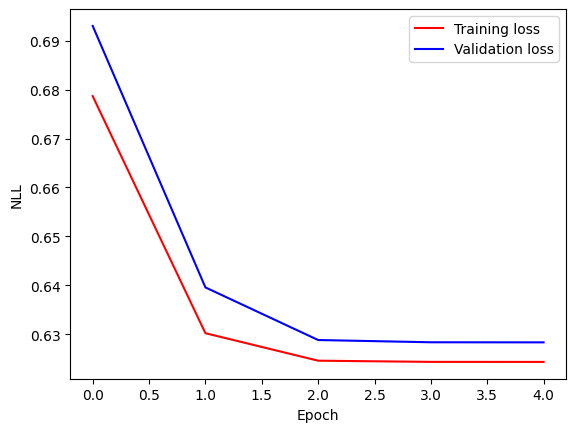

In [ ]:
# plot loss curve
plt.figure()
plt.plot(epoch, training_loss, 'r', label='Training loss',)
plt.plot(epoch, validation_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()

In [ ]:
# Get first sentence in validation set
inputs, targets = validation_x_tensor[0], validation_y_tensor[0]
outputs = best_model.forward(inputs.reshape(1,vocab_size)).data.numpy()

print('\nInput sequence:')
print(validation_data_r[0])

print('\nTarget sequence:')
print(targets)

preds = np.argmax(outputs)
print('\nPredicted sequence:')
print(preds)

print('\nChatbot response:')
best_model.generate_resp(inputs.reshape(1,vocab_size))


Input sequence:
disappointed .

Target sequence:
tensor(0)

Predicted sequence:
0

Chatbot response:
We are improving


# Task 1.2 Transformer

Refer to https://www.youtube.com/watch?v=kCc8FmEb1nY

In [2]:
# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0

In [3]:
torch.manual_seed(1337)

!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)

# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

--2024-04-17 13:13:19--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.05s   

2024-04-17 13:13:20 (19.8 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [ ]:
len(train_data)

1003854

In [4]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx


In [ ]:
model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

0.209729 M parameters


In [ ]:
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))

step 0: train loss 4.4116, val loss 4.4022
step 100: train loss 2.6568, val loss 2.6670
step 200: train loss 2.5090, val loss 2.5058
step 300: train loss 2.4194, val loss 2.4335
step 400: train loss 2.3503, val loss 2.3567
step 500: train loss 2.2964, val loss 2.3131
step 600: train loss 2.2404, val loss 2.2494
step 700: train loss 2.2043, val loss 2.2177
step 800: train loss 2.1629, val loss 2.1856
step 900: train loss 2.1240, val loss 2.1500
step 1000: train loss 2.1015, val loss 2.1286
step 1100: train loss 2.0685, val loss 2.1178
step 1200: train loss 2.0382, val loss 2.0792
step 1300: train loss 2.0251, val loss 2.0637
step 1400: train loss 1.9940, val loss 2.0377
step 1500: train loss 1.9691, val loss 2.0310
step 1600: train loss 1.9631, val loss 2.0481
step 1700: train loss 1.9402, val loss 2.0124
step 1800: train loss 1.9091, val loss 1.9958
step 1900: train loss 1.9069, val loss 1.9857
step 2000: train loss 1.8835, val loss 1.9925
step 2100: train loss 1.8699, val loss 1.9730


# Task 1.3 modify the Chatbot

In [8]:
class LSTM(nn.Module):
    def __init__(self, hidden_size = 25):
        super(LSTM, self).__init__()
        num_layers = 1
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        # Recurrent layer
        self.lstm = nn.LSTM(input_size=vocab_size,
                         hidden_size=hidden_size,
                         num_layers=num_layers,
                         bidirectional=False,
                         batch_first=True)

        # Output layer
        self.l_out = nn.Linear(in_features=hidden_size,
                            out_features=vocab_size, # out_features modified from 2 (binary classification) to vocab_size
                            bias=False)

    def forward(self, x, targets=None):
        # RNN returns output and last hidden state

        x = self.token_embedding_table(x)


        x, (h, c) = self.lstm(x)
        # Output layer
        x = self.l_out(x)
        B, S, C = x.shape
        if targets is None:
          loss = None
        else:
          x = x.view(B*S, C)
          targets = targets.view(B*S)
          loss = F.cross_entropy(x, targets)
        return x, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [12]:
model = LSTM()
m = model.to(device)
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

0.014985 M parameters


In [10]:
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
eval_interval = 200

for iter in range(max_iters):
      # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')
    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()


step 0: train loss 4.1846, val loss 4.1852
step 200: train loss 2.8770, val loss 2.8831
step 400: train loss 2.5679, val loss 2.5712
step 600: train loss 2.4421, val loss 2.4487
step 800: train loss 2.3760, val loss 2.3792
step 1000: train loss 2.3293, val loss 2.3447
step 1200: train loss 2.2939, val loss 2.3063
step 1400: train loss 2.2721, val loss 2.2899
step 1600: train loss 2.2468, val loss 2.2541
step 1800: train loss 2.2113, val loss 2.2353
step 2000: train loss 2.1967, val loss 2.2105
step 2200: train loss 2.1798, val loss 2.2026
step 2400: train loss 2.1647, val loss 2.1880
step 2600: train loss 2.1492, val loss 2.1763
step 2800: train loss 2.1363, val loss 2.1695
step 3000: train loss 2.1254, val loss 2.1523
step 3200: train loss 2.0989, val loss 2.1508
step 3400: train loss 2.0957, val loss 2.1416
step 3600: train loss 2.0979, val loss 2.1349
step 3800: train loss 2.0809, val loss 2.1321
step 4000: train loss 2.0803, val loss 2.1231
step 4200: train loss 2.0726, val loss 2.

In [11]:
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))


My Tourd to he mantecnctir shiosh nos and the by's thasbathory hese.

QUEPEZIO:

JUKAELY:
Men ond a not a perd
st;
And sution
suntut
and the Gare. you.

HORENTIZIO:
For hy for onreilt ose ther, eapachers, this the u's sastly Anding? Will'd to me
And prike whlald serinn'll he our moneiebimpe of arords; Srind nit.

COMIOLIRY:
I fore speark mell me ton tarn
Ind wen this and hit, onofe a doud
Siliote
Not cobt has were blaiosel-of crajestath
Or boed my tharldhath rvereing eat! itistarn thomuch in bows,
brays bent to mayerst, lite utaiw then whacyere arick, Hord, ond ats thin an dem, nous my dy.

No Ill senst siling, broveed
Prord the thand, hastiras whorr mast hee protherch lot dot rilice:
Hy pot dithen:
of and
Hore, ome, thy sir, whts anthy to fath
Bou tronter hin the wiml; Boy thmunse.

GLUKE LARENND CANCUS:
Ther; me uplocrither torh kid;

KCARDI3B ebai: dormayent thet, hear,
Wronce aqufrord wiml our nose If on heath thase Gokefemsom!
No be in so. I rone yo wimade, the notrentoup mes the